### Learning How to Use fastjet
Resources:
- https://fastjet.readthedocs.io/en/latest/Awkward.html#
- https://github.com/scikit-hep/fastjet/blob/main/README.md
- https://github.com/SUEPPhysics/SUEPCoffea_dask

In [1]:
import awkward as ak 
import numpy as np
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
from coffea.nanoevents.schemas.base import zip_forms
import dask_awkward as dak
import hist.dask as hda

In [3]:
events = NanoEventsFactory.from_root( 
    "../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" # make sure you update this path later
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root",
    treepath="events",
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

In [98]:
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)


# bit of a sketchy way of masking but it works and is quick so that's what I'm doing for now!
truth_arr = dak.ones_like(dak.num(events.PandoraPFOs)) == dak.ones_like(dak.num(events.PandoraPFOs)) 
no_muons = events.PandoraPFOs[muonsevent != truth_arr]

There is a specfic e+e- kt algorithm however it doesn't seem to work when called. Call is `fastjet.JetDefinition(ee_fastjet.kt_algorithm,0.4)`. There is also `ee_genkt_algorithm` which for $R>2$ and $p=1$ gives ee_kt apparantly. These are probably what we're going to use, I just need to work with them more to figure out what they actually want when called.

In [92]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,0.4) # right now defined with R = 0.4

In [99]:
cluster = fastjet.ClusterSequence(no_muons, jetdef).exclusive_jets(n_jets=2)

In [100]:
# this sets up the jets using Coffea

jets = dak.zip(
    {
        'x': cluster["px"],
        'y': cluster["py"],
        'z': cluster["pz"],
        't': cluster["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

{'from-uproot-bceefd3a21b0957eabdb642ed62ece56': ['PandoraPFOs.x',
  'PandoraPFOs.charge',
  'PandoraPFOs.pdgId',
  'PandoraPFOs.t',
  'PandoraPFOs.z',
  'PandoraPFOs.y']}

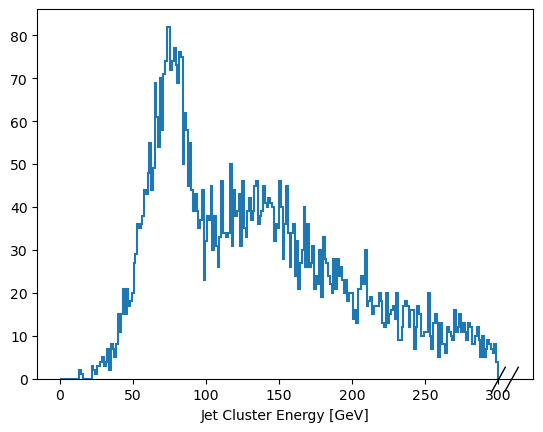

In [103]:
# energy of the filtered jets

energy_hist_clusters = (
    hda.Hist.new.Reg(250, 0, 300, name="energy", label="Jet Cluster Energy [GeV]") 
    .Double()
    .fill(dak.flatten(jets.energy))
)

energy_hist_clusters.compute().plot1d(label='Jet Clusters')
dak.necessary_columns(energy_hist_clusters)